In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import sklearn.linear_model
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import pydot 
import graphviz

In [6]:
raw_df = pd.read_csv("data/Berlin.May18_May19.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 310045 Airbnb listings


Unnamed: 0        Date    id  host_id             neighbourhood  \
0           0  2018-05-14  2015     2217          Brunnenstr. SÃ¼d   
1           1  2018-05-14  2776     3091           Wedding Zentrum   
2           2  2018-05-14  3176     3718  Prenzlauer Berg SÃ¼dwest   

         room_type  price  minimum_nights  calculated_host_listings_count  
0  Entire home/apt     60               5                               4  
1     Private room     55               3                               1  
2  Entire home/apt     90              62                               1

In [9]:
raw_df.date = pd.to_datetime(raw_df.Date) 


In [10]:
raw_df.isna().sum()


Unnamed: 0                        0
Date                              0
id                                0
host_id                           0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

In [11]:
raw_df.price.value_counts()

30      18572
50      17387
35      16799
40      16367
25      15496
        ...  
402         1
318         1
243         1
294         1
1612        1
Name: price, Length: 410, dtype: int64

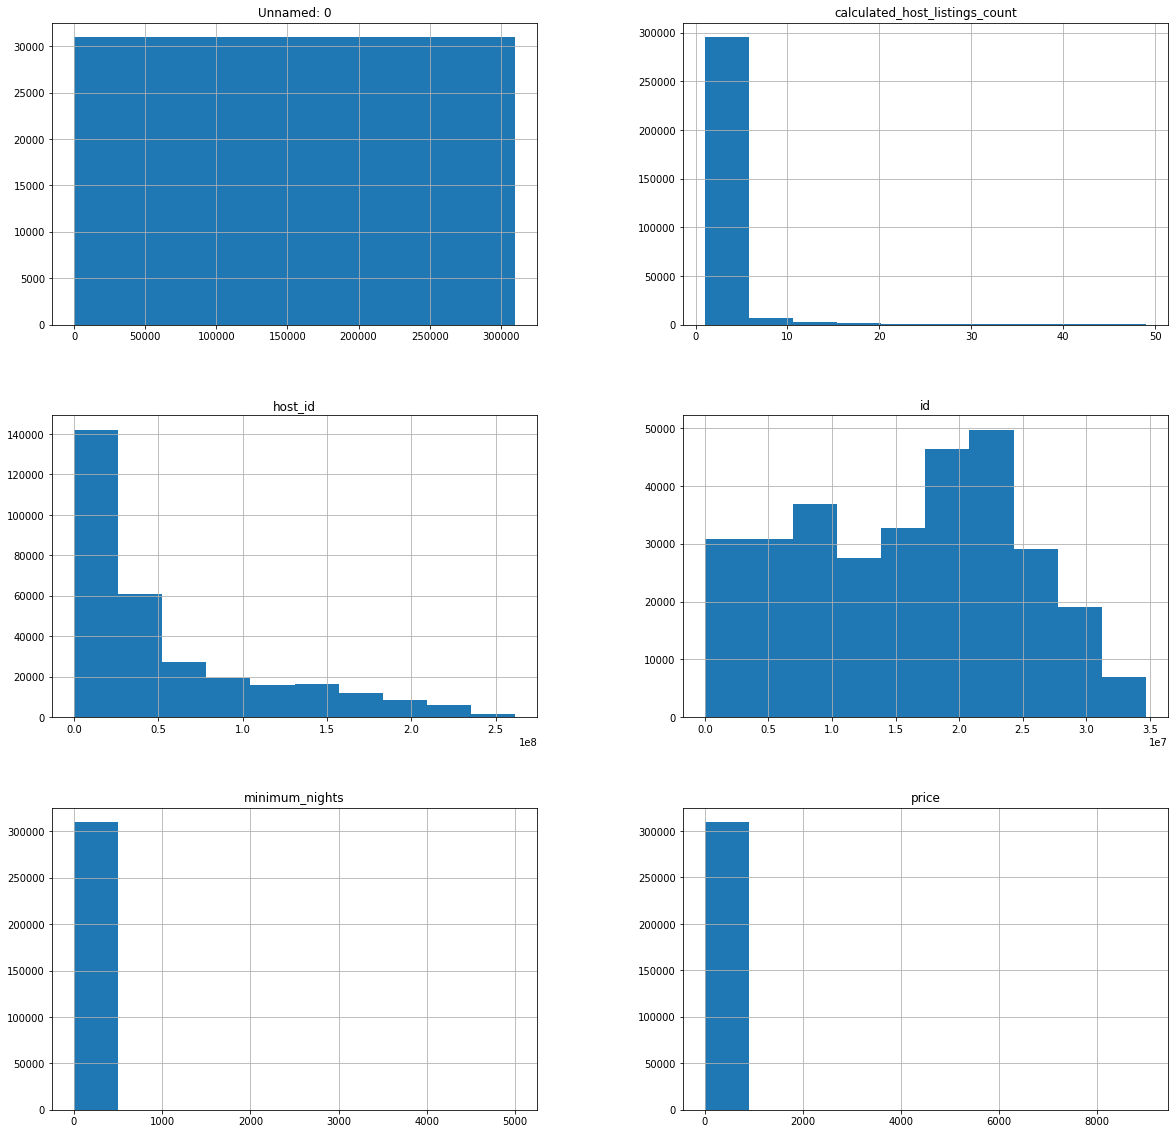

In [12]:
# Replacing columns with f/t with 0/1
raw_df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
raw_df.hist(figsize=(20,20));

In [13]:
raw_df.room_type.value_counts()


Private room       154089
Entire home/apt    152075
Shared room          3881
Name: room_type, dtype: int64

In [16]:

raw_df['Date']=pd.to_datetime(raw_df['Date'])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310045 entries, 0 to 310044
Data columns (total 9 columns):
Unnamed: 0                        310045 non-null int64
Date                              310045 non-null datetime64[ns]
id                                310045 non-null int64
host_id                           310045 non-null int64
neighbourhood                     310045 non-null object
room_type                         310045 non-null object
price                             310045 non-null int64
minimum_nights                    310045 non-null int64
calculated_host_listings_count    310045 non-null int64
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 21.3+ MB


In [17]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(raw_df.set_index('Date').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
Date
2018-01-01    64.03
2019-01-01    68.45
Freq: AS-JAN, Name: price, dtype: float64


In [18]:
host_listings_count = raw_df.host_id.value_counts()
host_listings_count

1625771      576
8250486      559
2293972      344
59442407     311
54942921     291
            ... 
83555030       1
56107463       1
151396792      1
4378918        1
176762918      1
Name: host_id, Length: 33263, dtype: int64

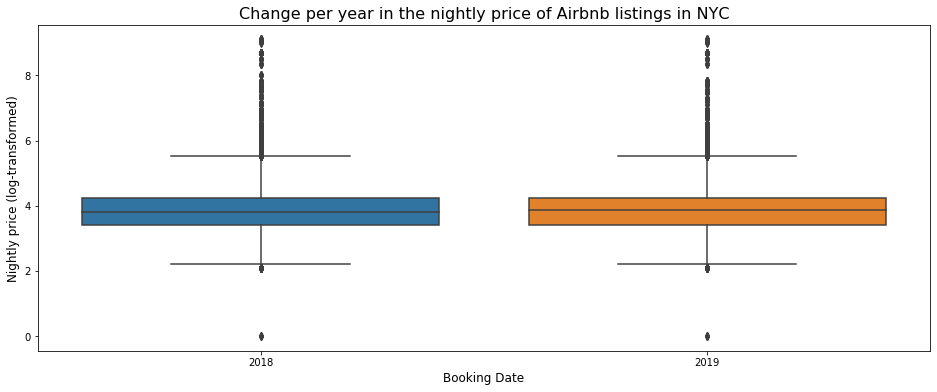

In [19]:
plt.figure(figsize=(16,6))
sns.boxplot(raw_df.date.dt.year, np.log(raw_df.price))
plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [20]:
raw_df.describe()

Unnamed: 0            id       host_id          price  \
count  310045.000000  3.100450e+05  3.100450e+05  310045.000000   
mean   155022.000000  1.585938e+07  5.427480e+07      65.708310   
std     89502.426443  8.726161e+06  5.884526e+07     194.826501   
min         0.000000  1.944000e+03  1.581000e+03       0.000000   
25%     77511.000000  8.117216e+06  9.283428e+06      30.000000   
50%    155022.000000  1.695407e+07  3.116870e+07      46.000000   
75%    232533.000000  2.252765e+07  8.085311e+07      70.000000   
max    310044.000000  3.468232e+07  2.616142e+08    9000.000000   

       minimum_nights  calculated_host_listings_count  
count   310045.000000                   310045.000000  
mean         6.440855                        1.927588  
std         34.562326                        3.771041  
min          1.000000                        1.000000  
25%          2.000000                        1.000000  
50%          2.000000                        1.000000  
75%          4.000000                        1.000000  
max       5000.000000                       49.000000

In [21]:
print(f"Nightly advertised prices range from ${min(raw_df.price)} to ${max(raw_df.price)}.")


Nightly advertised prices range from $0 to $9000.


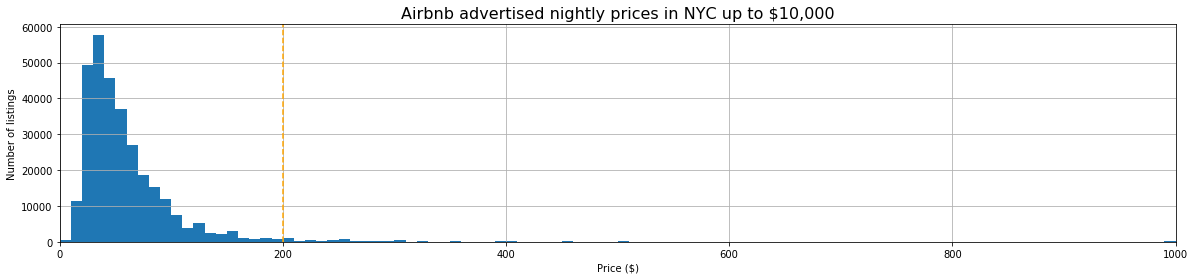

In [22]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

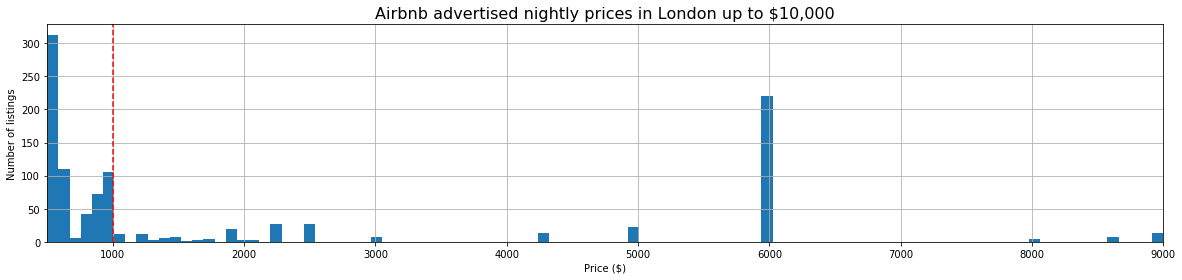

In [23]:
# Distribution of prices from $500 upwards
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(500, max(raw_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [24]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    raw_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

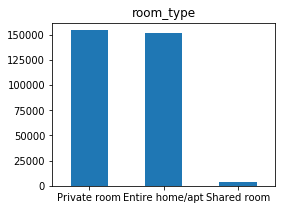

Private room       0.496989
Entire home/apt    0.490493
Shared room        0.012518
Name: room_type, dtype: float64


In [25]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(raw_df[col].value_counts(normalize=True))

In [26]:
transformed_df = pd.get_dummies(raw_df)

In [27]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

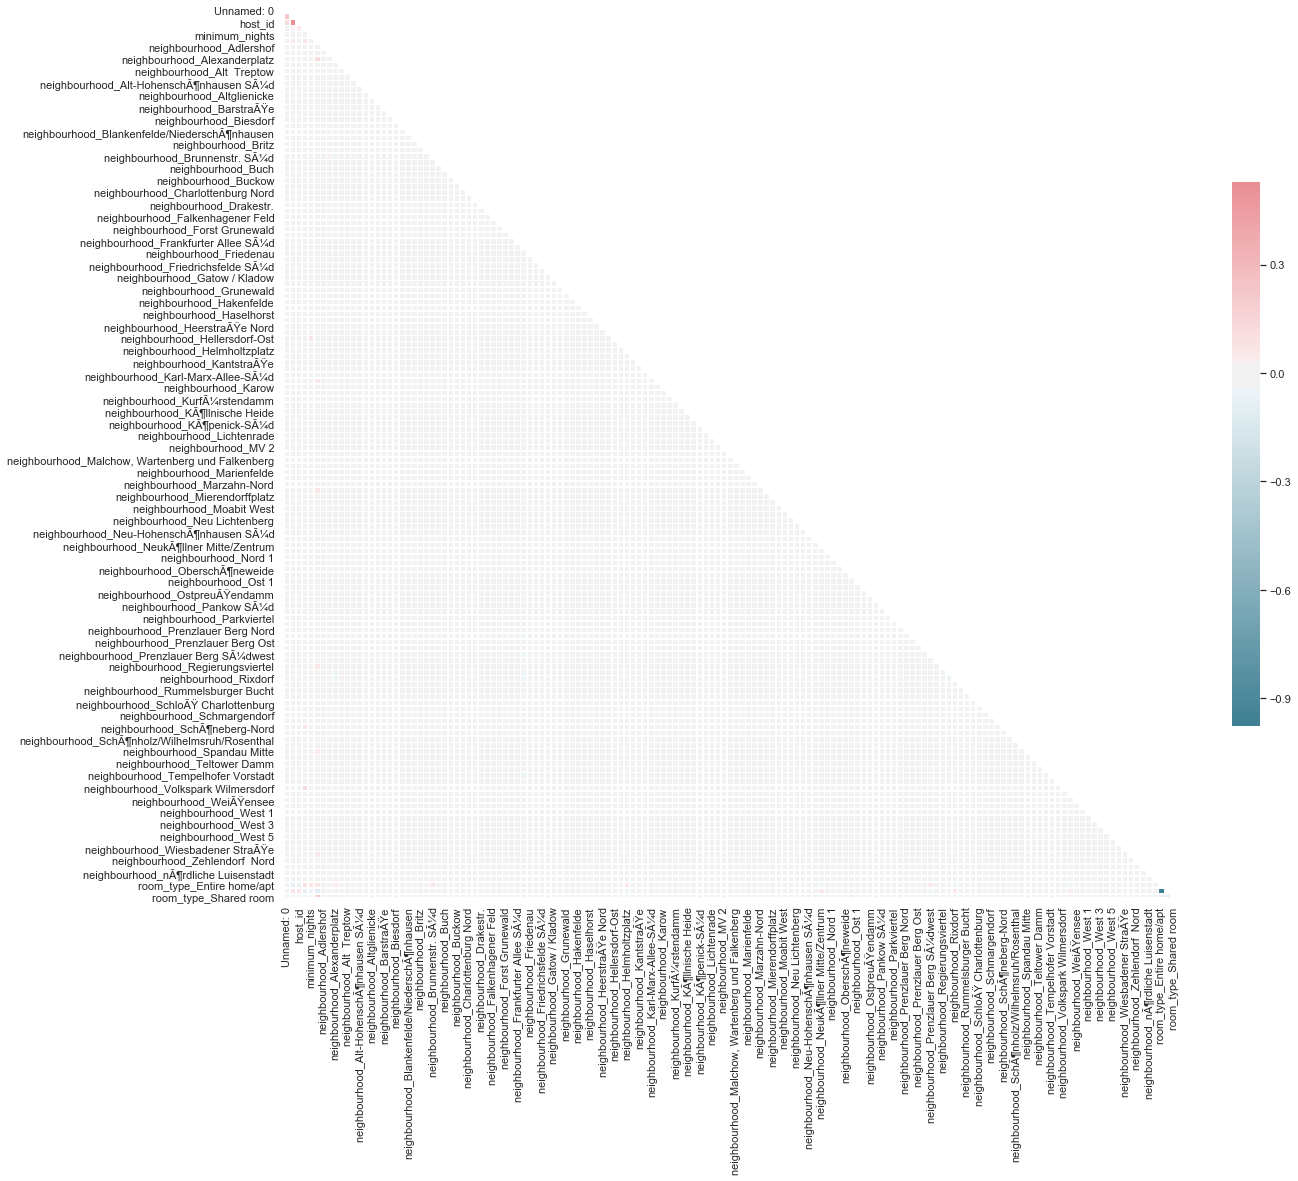

In [28]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

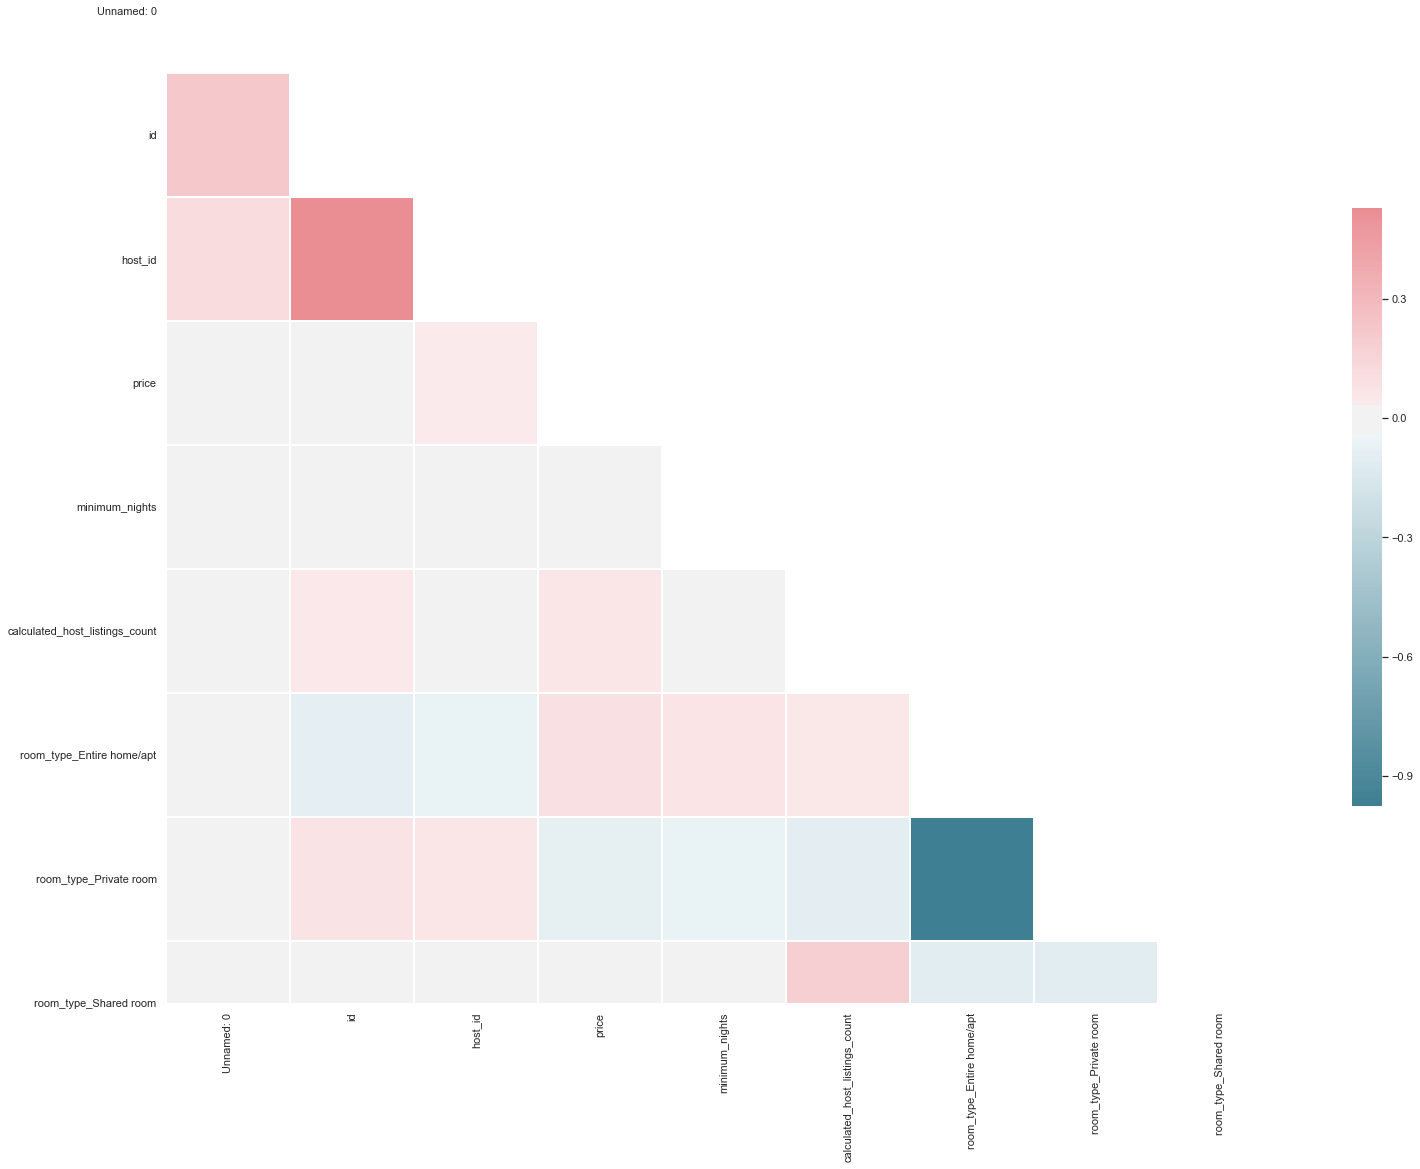

In [29]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

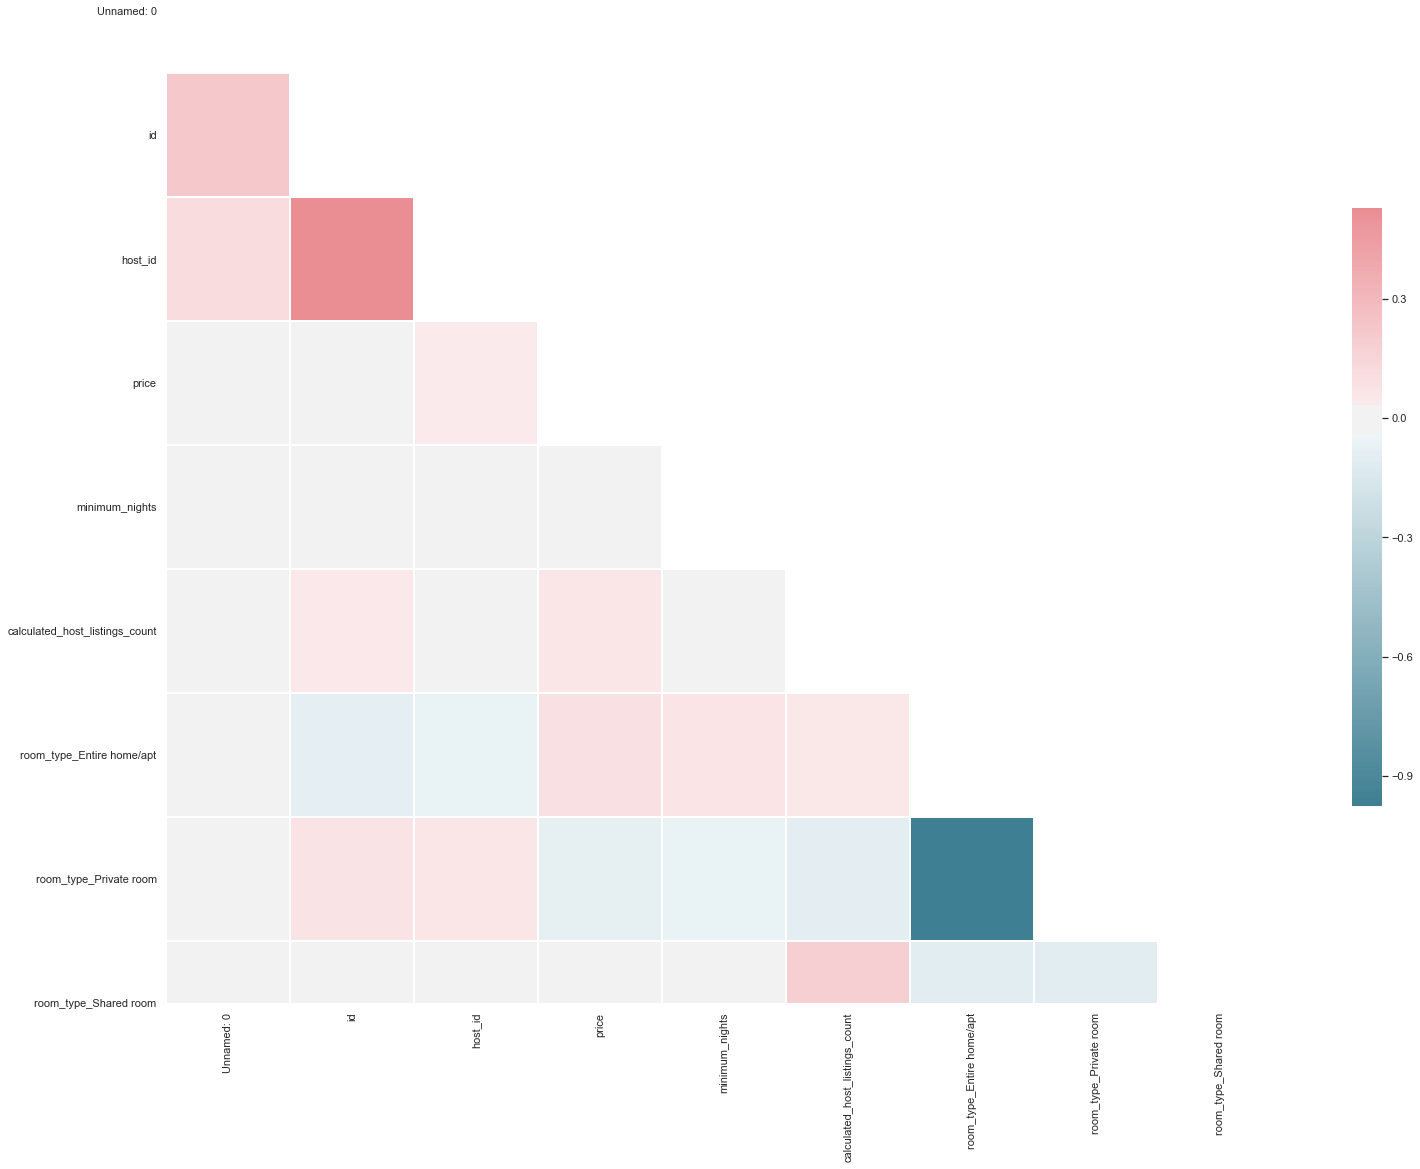

In [30]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [31]:
numerical_columns = ['price', 'id', 'calculated_host_listings_count', 'minimum_nights']


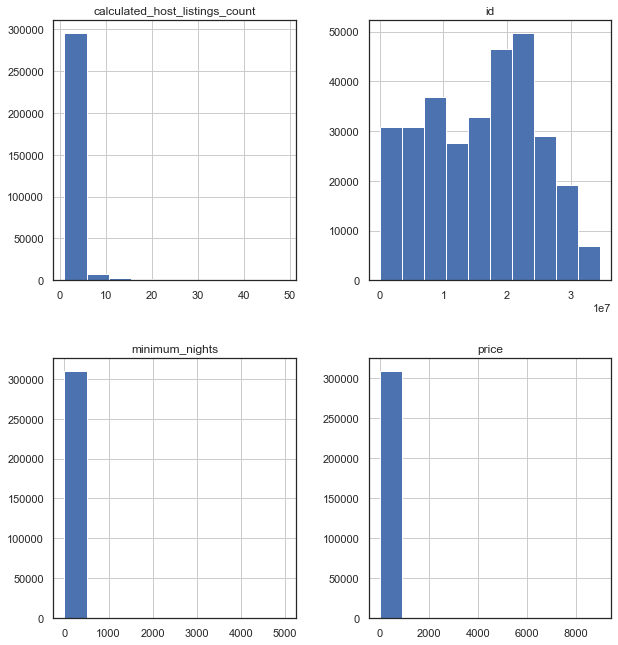

In [32]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [35]:
transformed_df['Date'] = pd.to_datetime(transformed_df['Date'])
transformed_df['day_of_week'] = transformed_df['Date'].dt.day_name()

In [41]:
transformed_df["new_year_day"] = transformed_df['Date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_df['day_of_the_year'] = transformed_df.apply(lambda x: (x['Date'] - x['new_year_day']).days + 1, axis=1)

In [42]:
transformed_df.tail(40)

Unnamed: 0       Date        id    host_id  ...  \
310005      310005 2019-05-14  34637714   33821412  ...   
310006      310006 2019-05-14  34638322   14227798  ...   
310007      310007 2019-05-14  34638507  135973057  ...   
310008      310008 2019-05-14  34638864   14098285  ...   
310009      310009 2019-05-14  34639457  251497729  ...   
310010      310010 2019-05-14  34642923  138658157  ...   
310011      310011 2019-05-14  34644413  245041680  ...   
310012      310012 2019-05-14  34644792  261366620  ...   
310013      310013 2019-05-14  34644971   68063826  ...   
310014      310014 2019-05-14  34645633  178494220  ...   
310015      310015 2019-05-14  34646313   97457092  ...   
310016      310016 2019-05-14  34646939  261382073  ...   
310017      310017 2019-05-14  34647288  199624438  ...   
310018      310018 2019-05-14  34647786  258036843  ...   
310019      310019 2019-05-14  34660474   38488471  ...   
310020      310020 2019-05-14  34661178   62816407  ...   
310021      310021 2019-05-14  34661358  219651637  ...   
310022      310022 2019-05-14  34662390   26413652  ...   
310023      310023 2019-05-14  34663347  129018052  ...   
310024      310024 2019-05-14  34663542  261505612  ...   
310025      310025 2019-05-14  34664686    6519019  ...   
310026      310026 2019-05-14  34666308   43279092  ...   
310027      310027 2019-05-14  34666919  195122046  ...   
310028      310028 2019-05-14  34669033   84060429  ...   
310029      310029 2019-05-14  34669043  188849025  ...   
310030      310030 2019-05-14  34671107  156028691  ...   
310031      310031 2019-05-14  34672106    5034211  ...   
310032      310032 2019-05-14  34672629  150465250  ...   
310033      310033 2019-05-14  34673672  177583779  ...   
310034      310034 2019-05-14  34674496   95227599  ...   
310035      310035 2019-05-14  34675305  151407333  ...   
310036      310036 2019-05-14  34676358   37884755  ...   
310037      310037 2019-05-14  34676655   18569702  ...   
310038      310038 2019-05-14  34677150   23794332  ...   
310039      310039 2019-05-14  34677601  261592052  ...   
310040      310040 2019-05-14  34678365  222154123  ...   
310041      310041 2019-05-14  34681094  261614182  ...   
310042      310042 2019-05-14  34681403   19220411  ...   
310043      310043 2019-05-14  34681413  261605200  ...   
310044      310044 2019-05-14  34682315  204800048  ...   

        room_type_Shared room  day_of_week  new_year_day  day_of_the_year  
310005                      0      Tuesday    2019-01-01              134  
310006                      0      Tuesday    2019-01-01              134  
310007                      0      Tuesday    2019-01-01              134  
310008                      0      Tuesday    2019-01-01              134  
310009                      0      Tuesday    2019-01-01              134  
310010                      0      Tuesday    2019-01-01              134  
310011                      0      Tuesday    2019-01-01              134  
310012                      0      Tuesday    2019-01-01              134  
310013                      0      Tuesday    2019-01-01              134  
310014                      0      Tuesday    2019-01-01              134  
310015                      0      Tuesday    2019-01-01              134  
310016                      0      Tuesday    2019-01-01              134  
310017                      0      Tuesday    2019-01-01              134  
310018                      0      Tuesday    2019-01-01              134  
310019                      0      Tuesday    2019-01-01              134  
310020                      0      Tuesday    2019-01-01              134  
310021                      0      Tuesday    2019-01-01              134  
310022                      0      Tuesday    2019-01-01              134  
310023                      0      Tuesday    2019-01-01              134  
310024                      0      Tuesday    2019-01-01            

In [44]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.drop(["Date", "new_year_day"], axis=1)),columns=X.drop(["Date", "new_year_day"], axis=1).columns)

ValueError: could not convert string to float: 'Monday'

In [45]:
X.head()

Unnamed: 0       Date    id  host_id  ...  room_type_Shared room  \
0           0 2018-05-14  2015     2217  ...                      0   
1           1 2018-05-14  2776     3091  ...                      0   
2           2 2018-05-14  3176     3718  ...                      0   
3           3 2018-05-14  3309     4108  ...                      0   
4           4 2018-05-14  7071    17391  ...                      0   

   day_of_week  new_year_day  day_of_the_year  
0       Monday    2018-01-01              134  
1       Monday    2018-01-01              134  
2       Monday    2018-01-01              134  
3       Monday    2018-01-01              134  
4       Monday    2018-01-01              134  

[5 rows x 150 columns]

In [46]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [47]:
# MOST SUCCESSFUL MODEL
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Date, day_of_week, new_year_day

In [50]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.tail()

AttributeError: Feature importance is not defined for Booster type None

In [51]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

NameError: name 'ft_weights_xgb_reg' is not defined

In [52]:
print("Median number of listings per host:", int(raw_df.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(raw_df.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(raw_df[raw_df.calculated_host_listings_count == 1])/len(raw_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 2
76% of listings are from hosts with one listing.


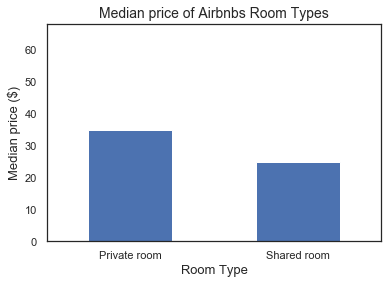

In [53]:
raw_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs Room Types', fontsize=14)
plt.xlabel('Room Type', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

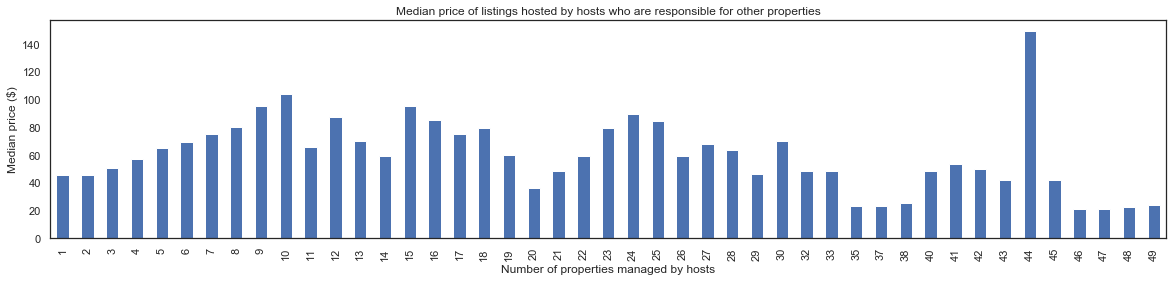

In [54]:
# Median price for different host listing counts
plt.figure()
raw_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');

In [55]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19328     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 118,401
Trainable params: 118,401
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [56]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [57]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [58]:
nn_model_evaluation(nn2)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [59]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               19328     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 250,241
Trainable params: 250,241
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [60]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [61]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [62]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               19328     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 250,241
Trainable params: 250,241
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [63]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [64]:
nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [65]:
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

# Visualising the neural network
SVG(model_to_dot(nn5, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               19328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [66]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [67]:
nn_model_evaluation(nn5, skip_epochs=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [68]:
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

# Visualising the neural network
SVG(model_to_dot(nn6, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               19328     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [69]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [70]:
nn_model_evaluation(nn6)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).